In [1]:
from LABNET import Neuron, Net

In [30]:
import random

In [2]:
dl_big = [
    ['i']
    ,['i']
    ,['i']
    ,['i']
    ,['i']
    ,['i']
    ,['i']
    ,['i'] #0-7 for inputs
    
    ,['fc',[0,1,2]]
    ,['fc',[-2,3,-4]]
    ,['fc',[3,4,5]]
    ,['fc',[3,5,7]]
    ,['fc',[0,7]] #8 - 12 for this layer
    
    ,['fc',[8,10]]
    ,['fc',[9,-11]]
    ,['fc',[12]]
    ,['fc',[-8,-9]] #13 - 16
    
    
    
    ,['o',[-13,14]]
    ,['o',[-14,15,-16]]
    ,['o',[-15,-16]]
    ,['o',[-13,16]]
    
]

In [3]:
nn_big = Net(dl_big)
nn_big.generate_inputs()
nn_big.generate_outputs()
nn_big.tensorize()

self.inputs and self.outputs are now tensors of shape torch.Size([256, 8]) and torch.Size([256, 4]) respectively!


In [4]:
nn_big.outputs

tensor([[False,  True, False, False],
        [False, False,  True, False],
        [False,  True, False, False],
        ...,
        [False, False, False,  True],
        [False, False, False,  True],
        [False, False, False,  True]])

In [5]:
nn_big.percent_true()

[tensor(0.0938), tensor(0.0781), tensor(0.1562), tensor(0.7500)]

In [6]:
nn_big.input_size

8

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

In [8]:
# Define the model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden_1 = nn.Linear(nn_big.input_size, 5) ##make these all variables duh
        self.hidden_2 = nn.Linear(5,4)
        self.output = nn.Linear(4, nn_big.output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden_1(x))
        x = self.relu(self.hidden_2(x))
        x = self.output(x)
        return x

In [9]:
model = MyModel()

In [78]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [79]:
input_data = nn_big.inputs.float()
output_data = nn_big.outputs.float()

In [80]:
input_data.dtype

torch.float32

In [81]:
# Training loop
samples = input_data.shape[0]
num_epochs = 20
hidden_layer_weights = torch.zeros(num_epochs* samples, 5, 8) #this should be num epochs by hidden size.  

data = list(zip(input_data, output_data))

for epoch in range(num_epochs):
    
    sample = 0
    
    random.shuffle(data)
    shuffled_inputs, shuffled_outputs = zip(*data)
    
    for inputs, targets in zip(shuffled_inputs, shuffled_outputs):
        inputs = inputs.unsqueeze(0)  
        targets = targets.unsqueeze(0)
    
        output = model(inputs)
    
        loss = criterion(output, targets)

    
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #print or store loss if you wanna
        #loss.item()

        #print(model.hidden_1.weight.shape) ##i also have biases here.  are those interesting??
        hidden_layer_weights[epoch * samples + sample] = model.hidden_1.weight
        sample += 1
        #print(model.hidden_2.weight)
        #print(model.output.weight)

# After training, you can use the model to make predictions
#test_input = torch.randn(1, 8)  # Single test input with 8 values
#predicted_output = model(test_input)
#print("Predicted output:", predicted_output)

In [82]:
hidden_layer_weights.shape

torch.Size([5120, 5, 8])

5120 40


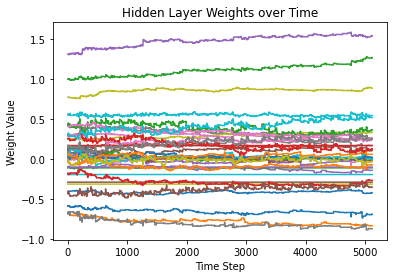

In [83]:
import matplotlib.pyplot as plt
import numpy as np
weights = hidden_layer_weights.detach().numpy()

shapes = weights.shape
weights = np.reshape(weights,(shapes[0],shapes[1]*shapes[2]))
#print(weights)
# Get the number of time steps and dimensions
num_time_steps, num_dimensions = weights.shape
print(num_time_steps,num_dimensions)
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the lines for each dimension
for i in range(num_dimensions):
    ax.plot(range(num_time_steps), weights[:, i], label=f"Dimension {i+1}")

# Set the labels and title
ax.set_xlabel('Time Step')
ax.set_ylabel('Weight Value')
ax.set_title('Hidden Layer Weights over Time')

# Add a legend how bout not
#ax.legend()

# Show the plot
plt.show()

##these look correct, just, it isn't stochastic.  its doing the full batch of all data at every iteration, its probably exactly right after like, 5 -10 samples.  


In [84]:

def plot_histogram(tensor, b):
    # Convert tensor to NumPy array
    tensor_np = tensor.numpy()

    # Calculate histogram using NumPy
    hist, bins = np.histogram(tensor_np, bins=b)

    # Plot histogram
    plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]), align='edge')

    # Add labels and title
    plt.xlabel('Bins')
    plt.ylabel('Frequency')
    plt.title('Histogram')

    # Show the plot
    plt.show()

In [85]:
differences = (hidden_layer_weights[-1] - hidden_layer_weights[0]).flatten().detach()

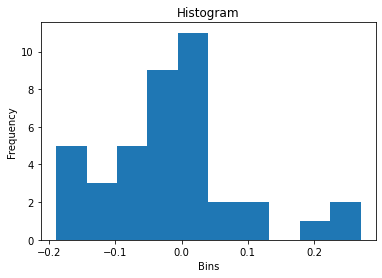

In [86]:
plot_histogram(differences, b=10)

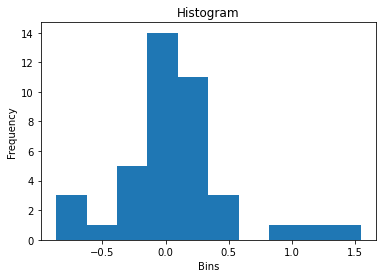

In [87]:
plot_histogram(hidden_layer_weights[-1].detach(), b=10)